In [88]:
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedKFold, RepeatedStratifiedKFold

### Utility functions

In [2]:
def custom_distance(dist):
    """Custom distance function"""
    return dist * np.exp(dist)

def normalize(x):
    """Feature-wise normalization"""
    return (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))

def standardize(x):
    """Feature-wise standarization"""
    return (x - x.mean(axis=0)) / x.std(axis=0)

In [99]:
def predict_and_plot(model: KNeighborsClassifier, X_test: pd.DataFrame, y_test: pd.DataFrame):
    """
    Run inference on the given model and plot confusion matrix
    with confusion matrix-based metrics.
    """
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred, zero_division=0))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test.squeeze())
    plt.show()

def eval_knn(
        data: pd.DataFrame, 
        k: int = 5, 
        weights: str = "uniform", 
        metric: str = "minkowski", 
        cv: str = 5, 
        preprocess: callable = lambda x: x,
        stratify: bool = False,
        repeats: int = 1
    ):
    """
    Evaluates KNN for given parameters
    """
    if weights == "custom":
        weights = custom_distance

    # Split data and preprocess
    X, y = data.drop("class", axis=1), data["class"]
    X = preprocess(X)

    # Choose folding mode
    if stratify:
        kfold = RepeatedStratifiedKFold(n_splits=cv, n_repeats=repeats)
    else:
        kfold = RepeatedKFold(n_splits=cv, n_repeats=repeats)

    model = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weights)
    cv_scores = cross_val_score(model, X, np.ravel(y), scoring='f1_weighted', cv=kfold)
    
    return cv_scores


def benchmark_cross_validation_preprocessors(data: pd.DataFrame, cvs: List[int], stratify: bool = False, repeats: int = 1):
    """
    Benchmark cross validation for all preprocessing modes
    """
    main_fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
    main_fig.suptitle("Boxplots of F1-score for different values of folds in cross-validation and different preprocessing techniques", fontsize=16)
    
    preprocessors = {
        "no-preprocessing": lambda x: x,
        "normalization": normalize,
        "standarization": standardize
    }

    for i, (ax, (name, preprocess)) in enumerate(zip(axes, preprocessors.items())):
        cv_scores = {cv: eval_knn(data, cv=cv, preprocess=preprocess, stratify=stratify, repeats=repeats) for cv in cvs}
        cv_scores = pd.DataFrame.from_dict(cv_scores, orient='index')
        cv_scores.T.boxplot(ax=ax)

        ax.set_title(name)
        ax.set_xlabel("Number of folds")
        
        if i == 0:
            ax.set_ylabel("F1-score (weighted)")

    plt.tight_layout()
    plt.show()


def knn_grid_search(
    data: pd.DataFrame, 
    metrics: List[str],
    weights: List[int], 
    k: int, 
    cv: int, 
    preprocess: callable = lambda x: x,
    stratify: bool = False,
    repeats: int = 1
):
    """
    Plots grid search for metrics and weights and plots series of boxplots
    """
    main_fig, axes = plt.subplots(len(weights), len(metrics), figsize=(20, 12), sharey=True, sharex=True)
    main_fig.suptitle("Boxplots of F1-score (weighted)", fontsize=20)

    for i, weight in enumerate(weights):
        for j, metric in enumerate(metrics):
            scores = {ki: eval_knn(data, ki, weight, metric, cv, preprocess=preprocess, stratify=stratify, repeats=repeats) for ki in range(1, k)}
            scores = pd.DataFrame.from_dict(scores, orient='index')

            fig = scores.T.boxplot(ax=axes[i, j])
            fig.set_title(f"weights={weight}, metric={metric}")

            if i == len(weights) - 1:
                fig.set_xlabel("Number of neighbours")

            if j == 0:
                fig.set_ylabel("F1-score (weighted)")

    plt.tight_layout()
    plt.show()

# IRIS

## 1. Ładowanie zbioru danych

In [4]:
dir = "../Lista 0/zbiory/iris.data"
iris_data = pd.read_csv(dir, names=["sepal-length", "sepal-width", "petal-length", "petal-width", "class"])

iris_data.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## 2. Trenowanie z domyślnymi parametrami

Klasyfikator KNN jako domyślnych wartości używa:
* ilość sąsiadów: $2$
* metryka: Minkowski z $p = 2$, czyli Euklides 
* głosowanie (weight): większościowe (uniform)

### 2.1 Podział zbioru

2.1.1. Random split

Dzielimy zbiór na losowe podzbiory podanej wielkości.

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         9
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



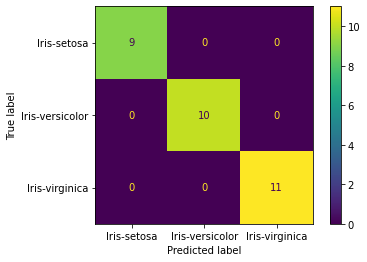

In [5]:
train_data, test_data = train_test_split(iris_data, train_size=0.8)

X_train, y_train = np.split(train_data, [-1], axis=1)
X_test, y_test = np.split(test_data, [-1], axis=1)

model = KNeighborsClassifier()
model.fit(X_train, y_train.squeeze())

predict_and_plot(model, X_test, y_test)

2.1.2. Stratified split

Najpierw dzielimy zbiór na podzbiory według przynależności do klasy, a następnie dla każdego podzbioru dokonujemy losowego podziału na zbiór treningowy i testowy według zadanych wielkości. W taki sposób zapewniamy, że rozkład klas w zbiorze treningowym jak i testowym jest taki sam - klasy są równie dobrze reprezentowane.

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      0.90      0.90        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30



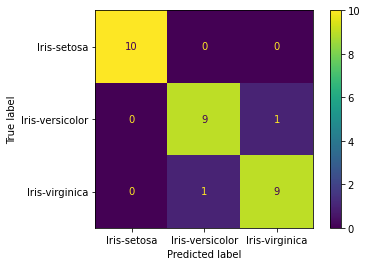

In [6]:
train_data, test_data = train_test_split(iris_data, train_size=0.8, stratify=iris_data["class"])

X_train_str, y_train_str = np.split(train_data, [-1], axis=1)
X_test_str, y_test_str = np.split(test_data, [-1], axis=1)

model = KNeighborsClassifier()
model.fit(X_train_str, y_train_str.squeeze())

predict_and_plot(model, X_test_str, y_test_str)

## 3. Trenowanie z walidacją krzyżową

Walidacja krzyżowa wielkości `k` polega na podziale zbioru danych na `k` równych (w kontekście ilości próbek - można też ze stratyfikacją) rozłącznych podzbiorów. Następnie tworzone jest `k` zbiorów danych, dla których wcześniej wyodrębnione podzbiory stanowią podzbiory walidacyjne, natomiast ich dopełnienie jest zbiorem treningowym. W taki sposób jakośc modelu jest lepiej ewaluowana, gdyż nie pomijamy żadnych danych jakie posiadamy w kontekście ewaluacji - arbitralny podział może nie brać poprawnie pod uwagę potencjalnych outlierów. 

W tej sekcji będziemy benchmarkować jakość modelu dla parametrów:
* ilość splitów: 2, 5, 10
* rodzaj preprocessingu: brak, normalizacja, standaryzacja
* stratyfikacja oraz jej brak

### 3.1 Walidacja krzyżowa z losowymi splitami

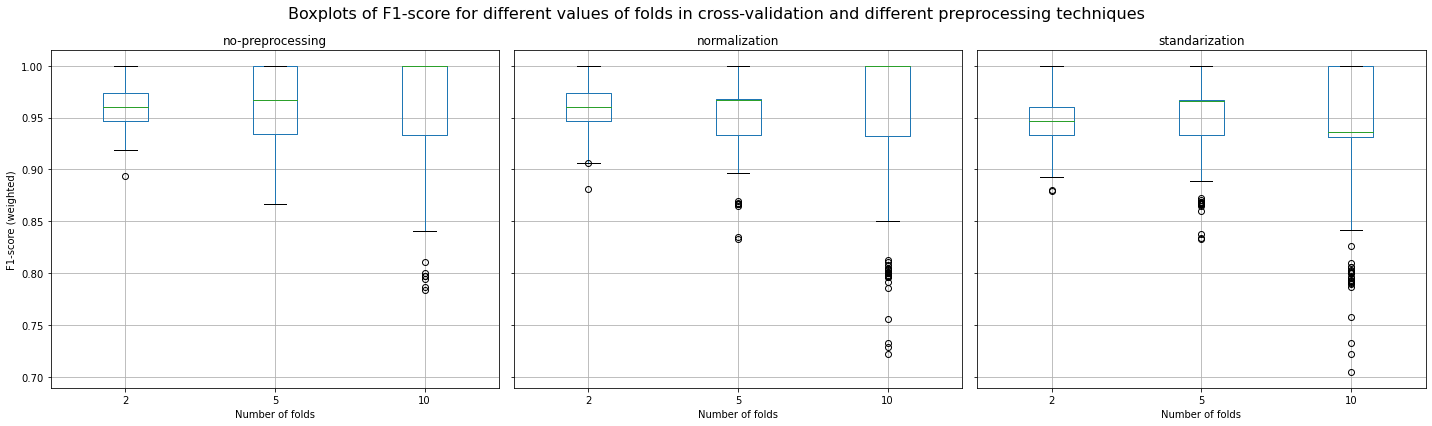

In [101]:
benchmark_cross_validation_preprocessors(iris_data, cvs=[2, 5, 10], repeats=100)

### 3.2 Walidacja krzyżowa ze stratyfikowanymi splitami

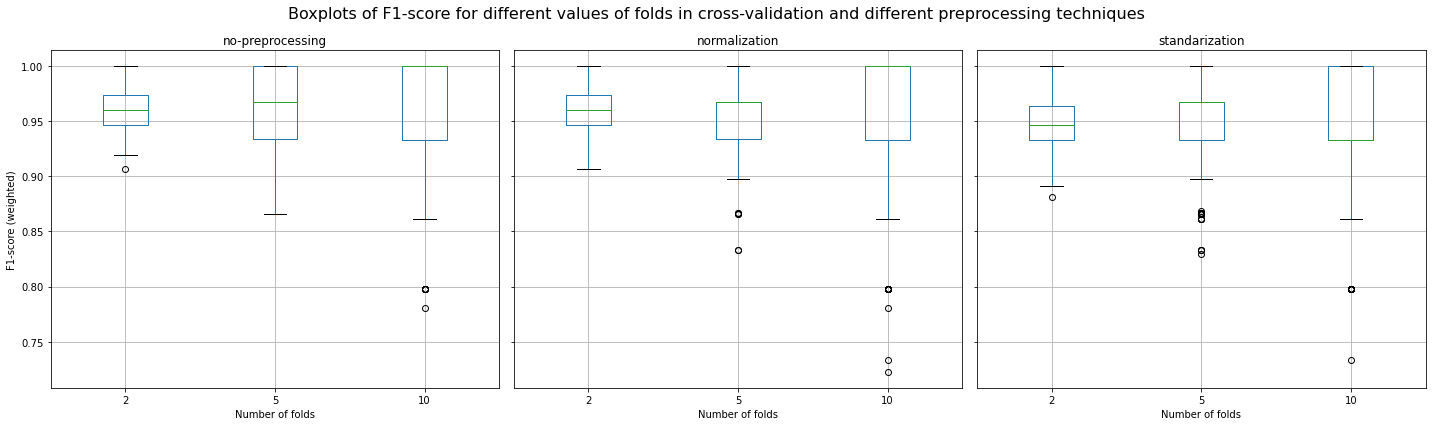

In [102]:
benchmark_cross_validation_preprocessors(iris_data, cvs=[2, 5, 10], stratify=True, repeats=100)

Ilość foldów w walidacji krzyżowej wpływa na to na jakiej ilości danych trenowane są modele - im więcej splitów tym mniejsze pojedyczne zbiory walidacyjne, zatem większe zbiory treningowe.

## 4. Porównanie jakości modelu dla różnych wartości parametrów

Na podstawie powyższych eksperymentów będziemy używać:
* stratyfikacji
* walidacji krzyżowej z 5 foldami
* braku preprocessing'u

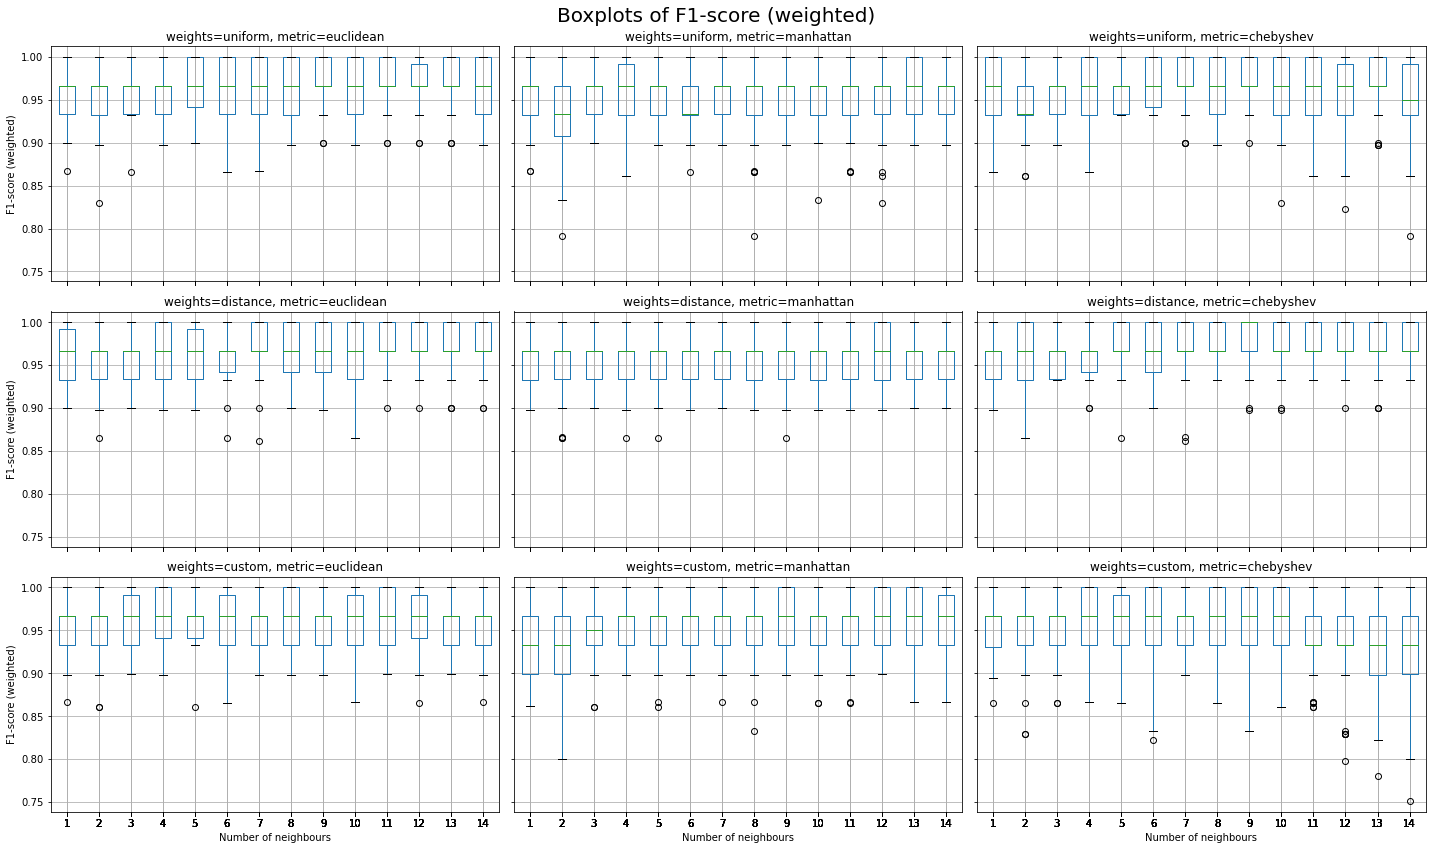

In [50]:
knn_grid_search(
    iris_data, 
    metrics=["euclidean", "manhattan", "chebyshev"], 
    weights=["uniform", "distance", "custom"], 
    k=15, 
    cv=5, 
    stratify=True,
    repeats=10
)

# GLASS

## 1. Ładowanie zbioru danych

In [53]:
dir = "../Lista 0/zbiory/glass.data"
glass_data = pd.read_csv(dir, names=["RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "class"]).reset_index()
glass_data = glass_data.drop("index", axis=1)

# With labels confusion matrix is very clotted and unreadable
# class_map = {
#     1: "building_windows_float_processed", 
#     2: "building_windows_non_float_processed",
#     3: "vehicle_windows_float_processed",
#     5: "containers",
#     6: "tableware",
#     7: "headlamps"
# }
# glass_data = glass_data.replace({"class": class_map})

glass_data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


## 2. Trenowanie z domyślnymi parametrami

Klasyfikator KNN jako domyślnych wartości używa:
* ilość sąsiadów: $2$
* metryka: Minkowski z $p = 2$, czyli Euklides 
* głosowanie (weight): większościowe (uniform)

### 2.1 Podział zbioru

2.1.1. Random split

              precision    recall  f1-score   support

         1.0       0.50      0.54      0.52        13
         2.0       0.44      0.54      0.48        13
         3.0       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         1
         7.0       1.00      0.83      0.91        12

    accuracy                           0.56        43
   macro avg       0.32      0.32      0.32        43
weighted avg       0.56      0.56      0.56        43



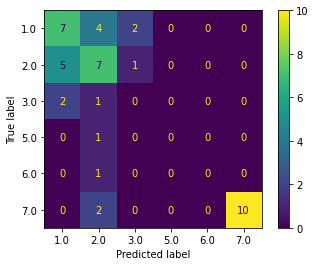

In [54]:
train_data, test_data = train_test_split(glass_data, train_size=0.8)

X_train, y_train = np.split(train_data, [-1], axis=1)
X_test, y_test = np.split(test_data, [-1], axis=1)

model = KNeighborsClassifier()
model.fit(X_train, y_train.squeeze())

predict_and_plot(model, X_test, y_test)

2.1.2. Stratified split

              precision    recall  f1-score   support

         1.0       0.48      0.71      0.57        14
         2.0       0.46      0.40      0.43        15
         3.0       0.00      0.00      0.00         3
         5.0       0.75      1.00      0.86         3
         6.0       0.00      0.00      0.00         2
         7.0       0.80      0.67      0.73         6

    accuracy                           0.53        43
   macro avg       0.41      0.46      0.43        43
weighted avg       0.48      0.53      0.50        43



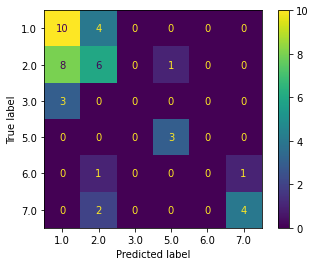

In [55]:
train_data, test_data = train_test_split(glass_data, train_size=0.8, stratify=glass_data["class"])

X_train_str, y_train_str = np.split(train_data, [-1], axis=1)
X_test_str, y_test_str = np.split(test_data, [-1], axis=1)

model = KNeighborsClassifier()
model.fit(X_train_str, y_train_str.squeeze())

predict_and_plot(model, X_test_str, y_test_str)

## 3. Trenowanie z walidacją krzyżową

Testujemy trzy różne ilości splitów: 2, 5, 10.

### 3.1 Walidacja krzyżowa z losowymi splitami

[0.58879658 0.57594132 0.64021837 0.61514725 0.6564998  0.64128345
 0.58375715 0.60502002 0.65632724 0.50036651 0.57419221 0.60165771
 0.63010772 0.60210741 0.60959193 0.62147375 0.61918573 0.61179663
 0.63862198 0.65440453 0.55065151 0.5582834  0.60872509 0.60524507
 0.59564519 0.64141328 0.59716648 0.59133567 0.54679689 0.64333082
 0.61487062 0.57913709 0.68624924 0.6390414  0.65511162 0.60761248
 0.59739289 0.57073853 0.65052634 0.64665252 0.64969466 0.57133677
 0.63038661 0.631099   0.62824507 0.58354027 0.5250877  0.60591067
 0.59404919 0.61300795 0.55067074 0.63673518 0.60034541 0.57034863
 0.68105718 0.54432538 0.62148947 0.59424184 0.61708038 0.61609068
 0.62550181 0.54996408 0.60290496 0.60706023 0.59307719 0.56990955
 0.53634647 0.6459754  0.55961484 0.57501805 0.6180166  0.58475626
 0.65112928 0.58564582 0.58472115 0.62799315 0.57852692 0.70676962
 0.59043003 0.56713334 0.60401667 0.66848062 0.64485323 0.56772494
 0.60684508 0.63955416 0.64512195 0.58271957 0.56761265 0.6527

KeyboardInterrupt: 

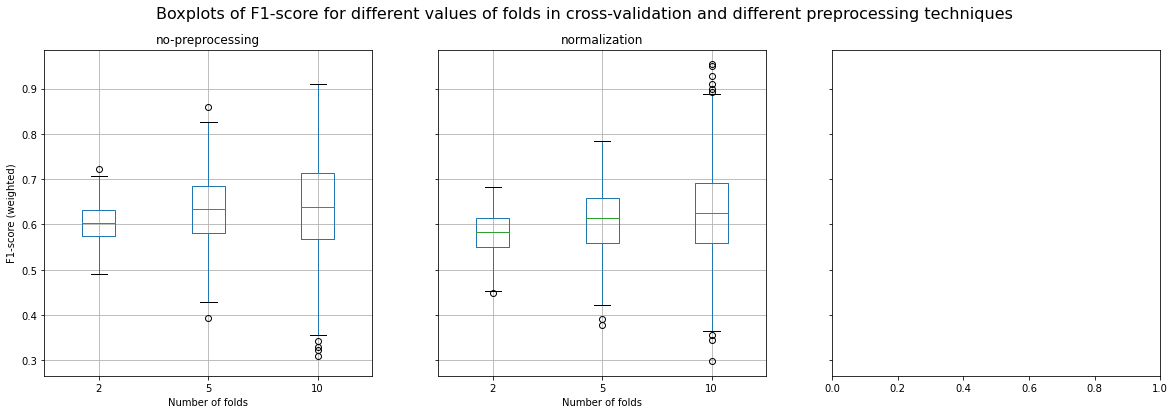

In [95]:
benchmark_cross_validation_preprocessors(glass_data, cvs=[2, 5, 10], repeats=100)

### 3.2 Walidacja krzyżowa ze stratyfikowanymi splitami

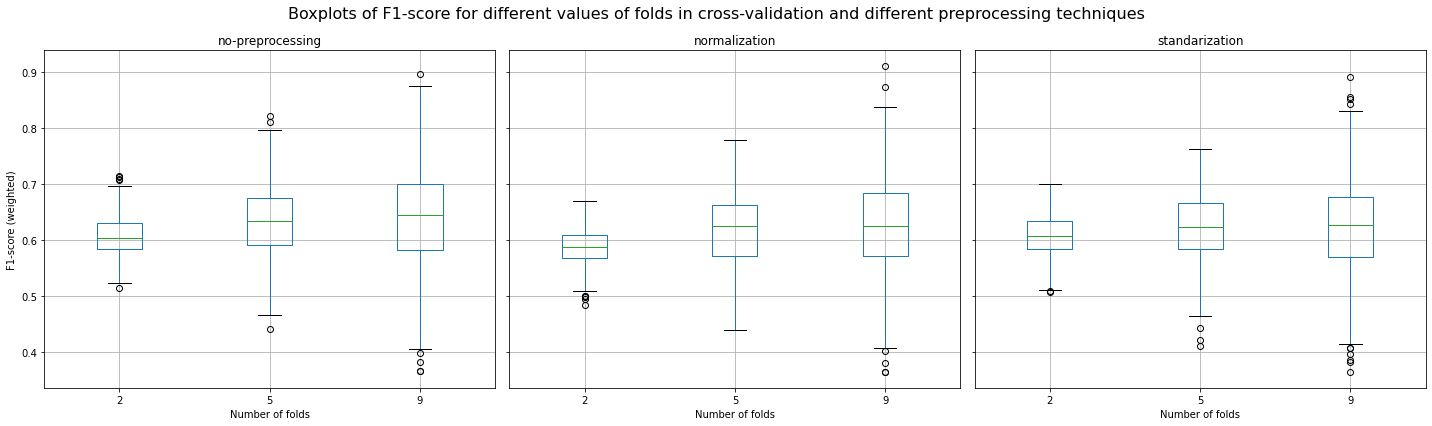

In [57]:
benchmark_cross_validation_preprocessors(glass_data, cvs=[2, 5, 9], repeats=100, stratify=True)

## 4. Porównanie jakości modelu dla różnych wartości parametrów

Na podstawie powyższych eksperymentów będziemy używać:
* stratyfikacji
* walidacji krzyżowej z 9 foldami
* standaryzacji

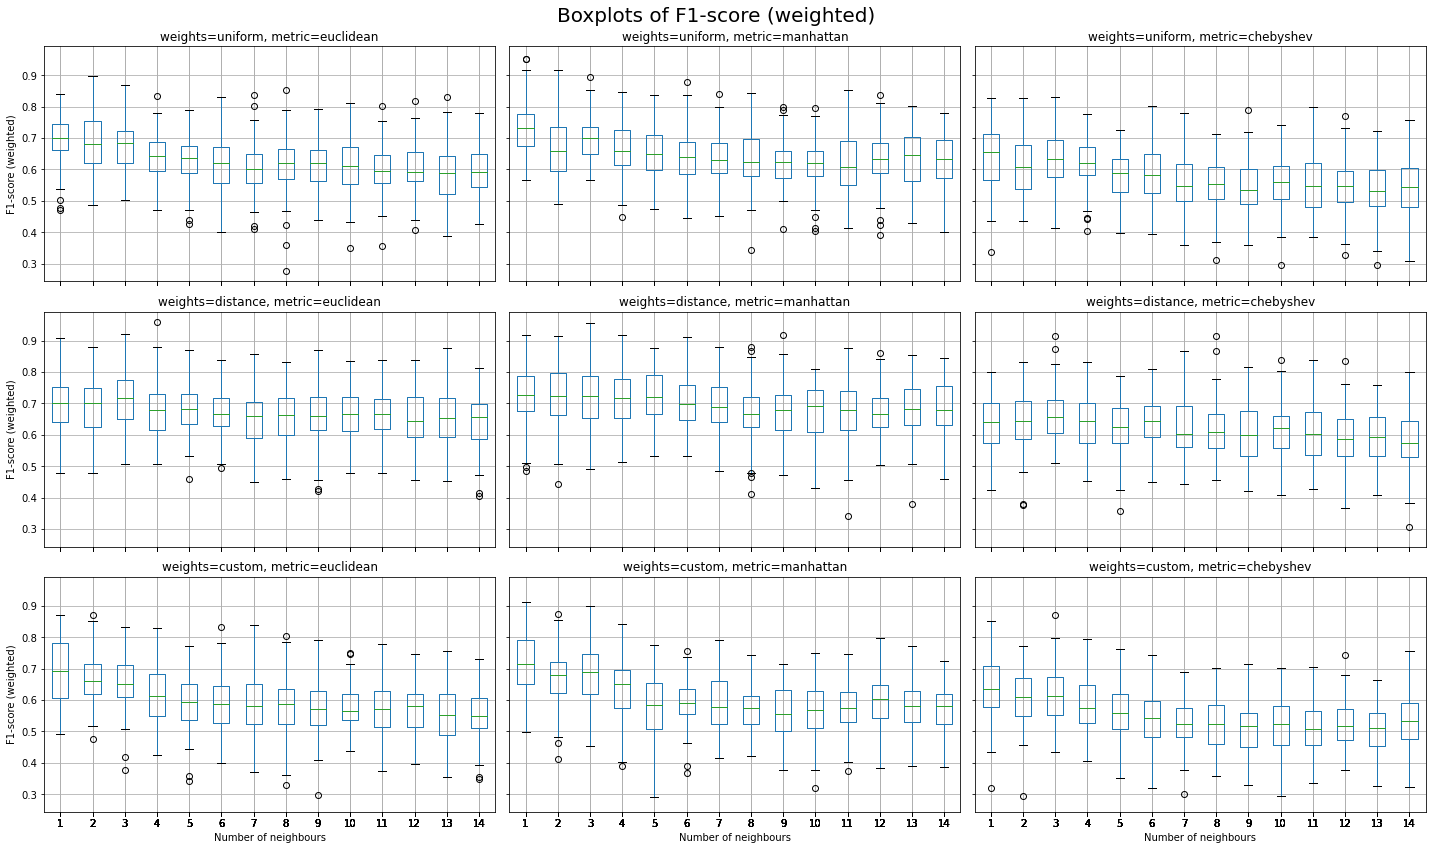

In [58]:
knn_grid_search(
    glass_data, 
    metrics=["euclidean", "manhattan", "chebyshev"], 
    weights=["uniform", "distance", "custom"], 
    k=15, 
    cv=9, 
    preprocess=standardize,
    stratify=True,
    repeats=10
)

# WINE

## 1. Ładowanie zbioru danych

In [59]:
dir = "../Lista 0/zbiory/wine.data"
wine_data = pd.read_csv(
    dir, 
    names=[
        "class", "Alcohol", "Malic acid", "Ash", "Alcanity of ash", "Magnesium", 
        "Total phenols", "Flavanoids", "Nonflavanoid phenosis", "Proanthocyanins",
        "Color intensity", "Hue", "OD280/OD315 of diluted wine", "Proline"
    ]
)

wine_data = wine_data[list(wine_data.columns.values)[1:] + ["class"]]

wine_data.head()

,Alcohol,Malic acid,Ash,Alcanity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenosis,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wine,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


## 2. Trenowanie z domyślnymi parametrami

Klasyfikator KNN jako domyślnych wartości używa:
* ilość sąsiadów: $2$
* metryka: Minkowski z $p = 2$, czyli Euklides 
* głosowanie (weight): większościowe (uniform)

### 2.1 Podział zbioru

2.1.1. Random split

              precision    recall  f1-score   support

         1.0       0.91      0.67      0.77        15
         2.0       0.60      0.69      0.64        13
         3.0       0.40      0.50      0.44         8

    accuracy                           0.64        36
   macro avg       0.64      0.62      0.62        36
weighted avg       0.68      0.64      0.65        36



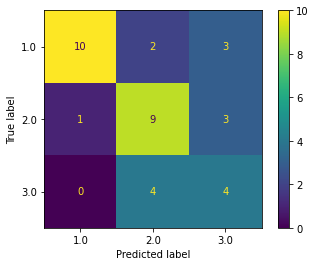

In [60]:
train_data, test_data = train_test_split(wine_data, train_size=0.8)

X_train, y_train = np.split(train_data, [-1], axis=1)
X_test, y_test = np.split(test_data, [-1], axis=1)

model = KNeighborsClassifier()
model.fit(X_train, y_train.squeeze())

predict_and_plot(model, X_test, y_test)

2.1.2. Stratified split

              precision    recall  f1-score   support

         1.0       0.83      0.83      0.83        12
         2.0       0.67      0.86      0.75        14
         3.0       0.67      0.40      0.50        10

    accuracy                           0.72        36
   macro avg       0.72      0.70      0.69        36
weighted avg       0.72      0.72      0.71        36



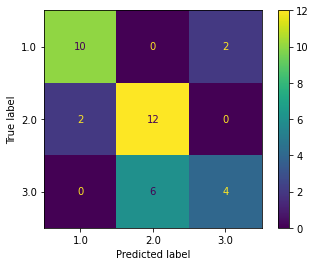

In [61]:
train_data, test_data = train_test_split(wine_data, train_size=0.8, stratify=wine_data["class"])

X_train_str, y_train_str = np.split(train_data, [-1], axis=1)
X_test_str, y_test_str = np.split(test_data, [-1], axis=1)

model = KNeighborsClassifier()
model.fit(X_train_str, y_train_str.squeeze())

predict_and_plot(model, X_test_str, y_test_str)

## 3. Trenowanie z walidacją krzyżową

Testujemy trzy różne ilości splitów: 2, 5, 10.

### 3.1 Walidacja krzyżowa z losowymi splitami

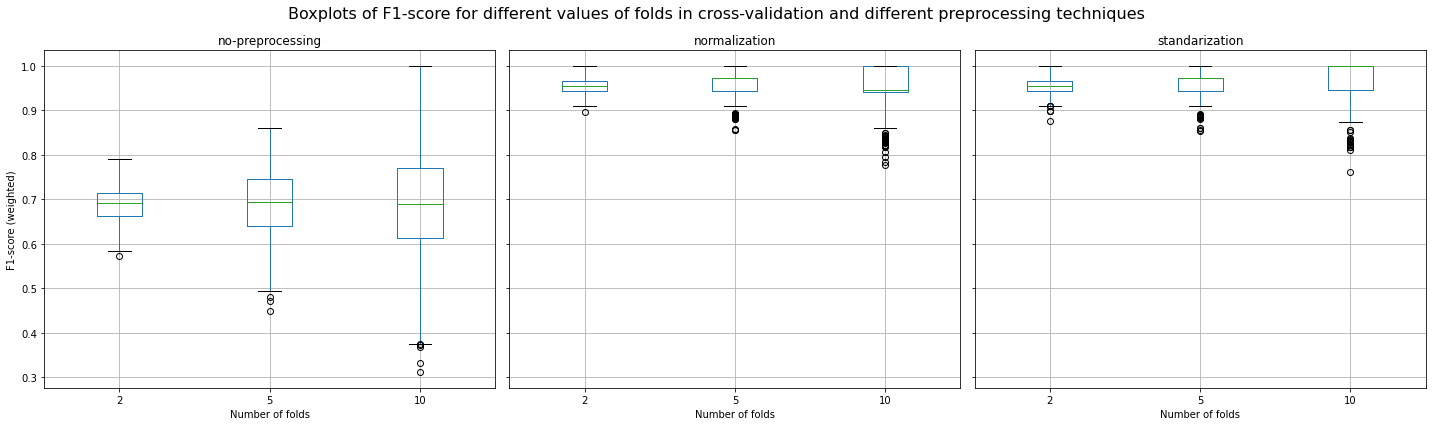

In [62]:
benchmark_cross_validation_preprocessors(wine_data, cvs=[2, 5, 10], repeats=100)

### 3.2 Walidacja krzyżowa ze stratyfikowanymi splitami

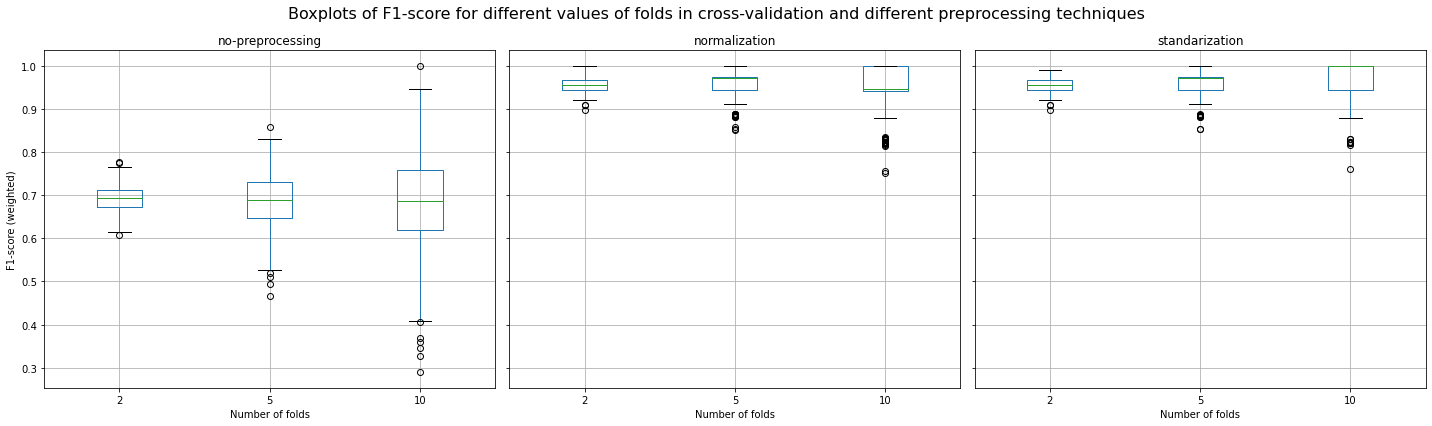

In [63]:
benchmark_cross_validation_preprocessors(wine_data, cvs=[2, 5, 10], repeats=100, stratify=True)

## 4. Porównanie jakości modelu dla różnych wartości parametrów

Na podstawie powyższych eksperymentów będziemy używać:
* stratyfikacji
* walidacji krzyżowej z 5 foldami
* normalizacja

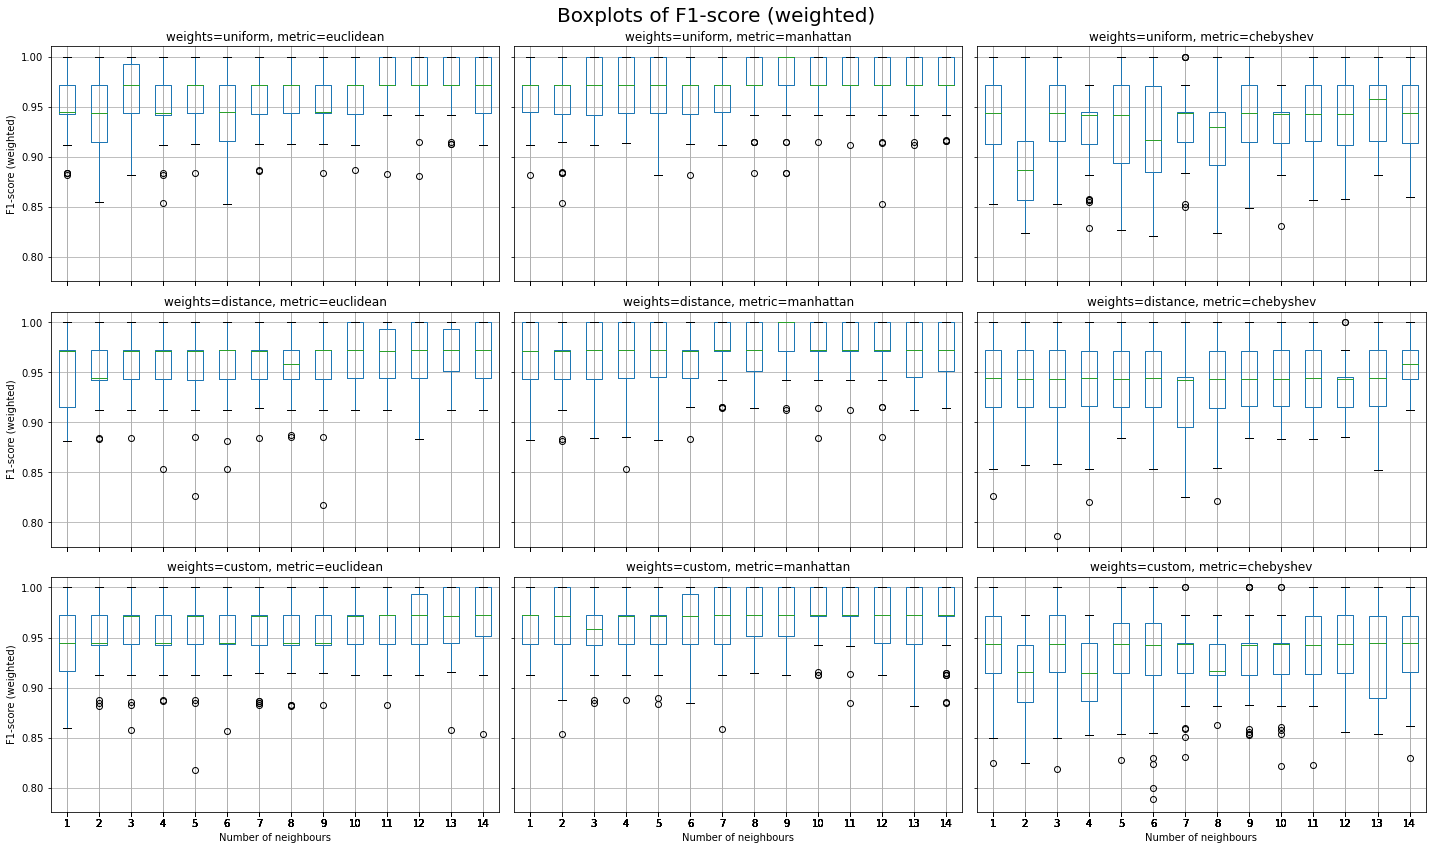

In [64]:
knn_grid_search(
    wine_data, 
    metrics=["euclidean", "manhattan", "chebyshev"], 
    weights=["uniform", "distance", "custom"], 
    k=15, 
    cv=5, 
    preprocess=normalize,
    stratify=True,
    repeats=10
)

# Pytania

### 1. Czy powinno używać się procedury mieszania danych (tj. *shuffle*)?

Odp: Dla modeli używających batchy, mieszanie danych jest zalecane, aby ograniczyć overfitting - nie wchodzą do modelu co epokę te same dane. W przypadku k-nn mieszanie danych nie ma za bardzo zastosowania z tego względu, że dla k-nn kolejność danych nie jest istotna. Predykcja jest wykonywana na podstawie szukania przykładów treningowych o najmniejszej odległości od ewaluowanej próbki - operacja minimum jest symetryczna, daje ten sam wynik bez znaczenia na permutacje danych.

### 2. Co jest modelem klasyfikacji w tym zadaniu? Dlaczego k-nn jest typu *lazy learning*?

Odp: W tym zadaniu klasyfikacja nowej próbki jest dokonywana na podstawie szukania najbardziej podobnych do niej próbek (sąsiadów) ze zbioru treningowego. Na podstawie odległości sąsiadów oraz ich klas predykowana jest klasa nowej próbki. K-nn jest typu *lazy-learning*, gdyż nie wymaga żadnego wcześniejszego uczenia - model zapamiętuje tylko próbki jakie otrzymał w zbiorze treningowym i tylko w ramach inferencji dokonuje obliczeń. 

### 3. Ile parametrów ma klasyfikator k-nn? Które z nich są istotne dla skuteczności?

Odp: Klasyfikator k-nn ma 3 różne parametry: ilość sąsiadów, sposób głosowania oraz funkcję odległości. Wszystkie trzy parametry są istotne dla skuteczności, natomiast jak mocno, który polepsza skuteczność modelu jest zależne od zbioru danych. 

### 4. Czym się różni walidacja krzyżowa stratyfikowana od "zwykłej"?

Odp: Podział stratyfikowany polega na podzieleniu zbioru na podzbiory w taki sposób aby wszystkie klasy były równo reprezentowane w każdym z podzbiorów.

### 5. Dlaczego zwykle nie stosujemy walidacji krzyżowej *leave-one-out*?

Odp: Walidacja krzyżowa *leave-one-out* polega na wykonaniu tylu splitów w walidacji krzyżowej ile jest elementów w zbiorze danych - dla każdego splitu mamy jeden element w zbiorze walidacyjnym. Z reguły nie stosuje się takiej techniki, gdyż jest ona bardzo czaso i zasobo-żerna oraz nie oferuje z praktycznego punktu widzenia lepszej ewaluacji niż np. 2 elementy w zbiorze walidacyjnym per split.

### 6. Czy k-nn wymaga standaryzacji/normalizacji danych?

Odp: K-nn wymaga standaryzacji/normalizacjia danych ze względu na to, że model jest oparty na liczeniu odległości pomiędzy próbkami. Gdy cechy mają różne dziedziny, model będzie bardziej zbiasowany w kierunku matchowania tej konkretnej cechy co nie ma żadnego uzasadnienia z formalnego punktu widzenia - wszystkie cechy powinniśmy uważać za równe chyba, że chcemy umieścić w modelowaniu jakąś wiedzę dziedzinową a priori.

### 7. Dlaczego miara Accuracy dla zbiorów niezbalansowanych jest mniej użyteczna niż miara F-score?

Odp: